# Airbnb Predicting Paris Listing Price 🏡

![](https://www.kent.ac.uk/events/images/paris-notre-dame-1920x1280.jpg)

The mission is to do a **complete data cleaning &amp; preparation**, and then **to fit regression model that predicts the listing price**!

In [1]:
# Download data as done below

#!wget "http://data.insideairbnb.com/france/ile-de-france/paris/2018-12-07/data/listings.csv.gz"
#!gunzip listings.csv.gz

--2021-01-19 16:00:21--  http://data.insideairbnb.com/france/ile-de-france/paris/2018-12-07/data/listings.csv.gz
Résolution de data.insideairbnb.com (data.insideairbnb.com)… 52.217.1.115
Connexion à data.insideairbnb.com (data.insideairbnb.com)|52.217.1.115|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 50567799 (48M) [application/x-gzip]
Sauvegarde en : « listings.csv.gz »

listings.csv.gz     100%[===================>]  48,22M  2,27MB/s    ds 15s     

2021-01-19 16:00:36 (3,26 MB/s) — « listings.csv.gz » sauvegardé [50567799/50567799]



In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt

# Data exploration & Cleaning

In [2]:
# TODO - Download and load dataset
file_path = os.path.join('..', '..', '..', 'data', 'listings.csv')
df = pd.read_csv(file_path)
df.shape


/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (43,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(59881, 96)

In [196]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [3]:
df.describe(include='O')

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,first_review,last_review,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,59881,59881,59807,57524,40516,59384,59881,35647,18606,38160,...,47389,47389,59881,14557,59119,59881,59881,59881,59881,59881
unique,59881,2,57244,56199,39554,58583,1,32885,16210,36492,...,2620,1655,2,13914,31,2,1,6,2,2
top,https://www.airbnb.com/rooms/26704452,2018-12-08,Studio,Located in a private residence in the heart of...,Located in a private residence in the heart of...,Located in a private residence in the heart of...,none,"Le Marais, it's the festive, fashion, artistic...",Benefits for You: • Towels & Linens Provide...,"•From Orly Airport: Take shuttle to ""Antony"",...",...,2018-09-09,2018-12-02,t,7510802047060,{PARIS},f,f,flexible,f,f
freq,1,37920,29,41,41,39,59881,123,88,16,...,150,1367,59880,9,58636,39974,59881,21561,59290,58767


- The dataset doesn't contain only data from Paris city. Thus, we make sure to filter only on Paris listings.

In [3]:
# Filtering on Paris
df = df[(df['jurisdiction_names'].isin(['{Paris}', '{PARIS}'])) & (df['is_location_exact'] == 't')]
print(f"We now have a dataset of shape: {df.shape}, we removed {59881 - df.shape[0]} lines.")

We now have a dataset of shape: (50298, 96), we removed 9583 lines.


- we will remove all the listings that have number of reviews equal to 0 as most of these will be NA.

In [4]:
df = df[df['number_of_reviews'] > 0]
df.shape

(40399, 96)

- we will input 0 where value is not explicitly specified within the listing for the following columns:
    `security_deposit`
    `cleaning_fee`

- we also convert `host_about` from NA to empty string to allow character count


In [5]:
df['security_deposit'] = df['security_deposit'].fillna('$0.00')


In [6]:
df['cleaning_fee'] = df['cleaning_fee'].fillna('$0.00')

In [7]:
df['host_about'] = df['host_about'].fillna('')

In [8]:
df['host_response_time'].value_counts()


within an hour        11578
within a few hours     5525
within a day           5336
a few days or more      712
Name: host_response_time, dtype: int64

In [9]:
df['host_response_rate'].isna().sum()

17248

In [10]:
df['host_is_superhost'].value_counts() 

f    35245
t     5154
Name: host_is_superhost, dtype: int64

In [11]:
df['host_listings_count'].value_counts()

1.0      30193
2.0       4764
3.0       1243
4.0        580
5.0        282
         ...  
192.0        1
172.0        1
80.0         1
38.0         1
53.0         1
Name: host_listings_count, Length: 74, dtype: int64

In [12]:
df.iloc[:, :50].isna().sum()

id                                  0
listing_url                         0
scrape_id                           0
last_scraped                        0
name                               25
summary                          1358
space                           11252
description                       188
experiences_offered                 0
neighborhood_overview           14531
notes                           26525
transit                         12732
access                          19199
interaction                     19521
house_rules                     19699
thumbnail_url                   40399
medium_url                      40399
picture_url                         0
xl_picture_url                  40399
host_id                             0
host_url                            0
host_name                           0
host_since                          0
host_location                      92
host_about                          0
host_response_time              17248
host_respons

In [13]:
df.iloc[:, 51:].isna().sum()

property_type                           0
room_type                               0
accommodates                            0
bathrooms                              47
bedrooms                               40
beds                                   15
bed_type                                0
amenities                               0
square_feet                         39220
price                                   0
weekly_price                        31355
monthly_price                       34321
security_deposit                        0
cleaning_fee                            0
guests_included                         0
extra_people                            0
minimum_nights                          0
maximum_nights                          0
calendar_updated                        0
has_availability                        0
availability_30                         0
availability_60                         0
availability_90                         0
availability_365                  

# Columns to keep  

   - `host_since` - can be used to calculate host experience based on duration since the first listing
   - `host_location` - we can use it to establish if host is local or not
   - `host_about` - since its only a text we will count number of characters
   - `host_is_superhost` - categorical t or f - describing highly rated and relaible hosts - https://www.airbnb.co.uk/superhost
   - `host_has_profile_pic` - categorical t or f - profiles with pictures are seen as more credible
   - `host_identity_verified` - categorical t or f - another credibility metric
   - `neighbourhood_cleansed` - we will use only for visualisation due to number of neighbourhoods 
   - `latitude` - we will use it later to visualise the data on the map
   - `longitude` - we will use it later to visualise the data on the map
   - `property_type` - categorical variable
   - `room_type` - categorical variable
   - `accommodates` - discrete value describing property
   - `bathrooms` - another discrete value describing property
   - `bedrooms` - another discrete value describing property
   - `beds` - another discrete value describing property
   - `bed_type` - categorical value describing property
   - `amenities` - due to number of unique features (over 100) we will only concentrate on the total number of amenities
   - `price` - price per night for number of included guests
   - `security_deposit` - another continous value assiociated with the cost
   - `cleaning_fee` - additional cost at the top of rent
   - `guests_included` - descrete value which we will use to evaluate the cost per person
   - `extra_people` - cost of additional person per night
   - `minimum_nights` - another discrete value that is cost related. Listing with high value of minimum nights are likely sublettings
   - `first_review` - 
   - `last_review` - we will use this field to filter out no longer active listings
   - `number_of_reviews` - total number of reviews in entire listing history
   - `review_scores_accuracy` - discrete value - numbers between 2 and 10
   - `review_scores_cleanliness` - discrete value - numbers between 2 and 10
   - `review_scores_checkin` - discrete value - numbers between 2 and 10
   - `review_scores_communication` - discrete value - numbers between 2 and 10
   - `review_scores_location` - discrete value - numbers between 2 and 10
   - `review_scores_value` - discrete value - numbers between 2 and 10
   - `instant_bookable` - categorical value - t or false
   - `cancellation_policy` - ordinal value with 5 categories that can be ordered from lowest to highest level of flexibility
   - `require_guest_profile_picture` - categorical value - t or false
   - `require_guest_phone_verification` - categorical value - t or false
   - `calculated_host_listings_count` - continious value which is actual number of host listings - another metric to measure host experience or to distinguish buisness from individual

In [12]:
columns_to_keep_global = ['id', 'last_scraped', 'host_name', 
                          'host_since', 'host_location',
                          'host_about', 'host_is_superhost',
                          'host_has_profile_pic', 'host_identity_verified',
                          'neighbourhood_cleansed',
                          'latitude', 'longitude', 'property_type', 
                          'room_type', 'accommodates', 'bathrooms',
                          'bedrooms', 'beds', 'bed_type', 'amenities',
                          'price', 'security_deposit', 'cleaning_fee',
                          'guests_included', 'extra_people', 'minimum_nights',
                          'first_review', 'last_review', 'number_of_reviews',
                          'review_scores_accuracy', 'review_scores_cleanliness',
                          'review_scores_checkin', 'review_scores_communication',
                          'review_scores_location', 'review_scores_value',
                          'instant_bookable', 'cancellation_policy', 
                          'require_guest_profile_picture', 'require_guest_phone_verification',
                          'calculated_host_listings_count', 'reviews_per_month' 
                         ]
len(columns_to_keep_global)
#'neighbourhood_group_cleansed'

41

In [13]:
df_global = df[columns_to_keep_global]

In [13]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40399 entries, 2 to 59875
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                40399 non-null  int64  
 1   last_scraped                      40399 non-null  object 
 2   host_name                         40399 non-null  object 
 3   host_since                        40399 non-null  object 
 4   host_location                     40307 non-null  object 
 5   host_about                        40399 non-null  object 
 6   host_is_superhost                 40399 non-null  object 
 7   host_has_profile_pic              40399 non-null  object 
 8   host_identity_verified            40399 non-null  object 
 9   neighbourhood_cleansed            40399 non-null  object 
 10  latitude                          40399 non-null  float64
 11  longitude                         40399 non-null  float64
 12  prop

In [14]:
df_global.isna().sum()

id                                     0
last_scraped                           0
host_name                              0
host_since                             0
host_location                         92
host_about                             0
host_is_superhost                      0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             47
bedrooms                              40
beds                                  15
bed_type                               0
amenities                              0
price                                  0
security_deposit                       0
cleaning_fee                           0
guests_included                        0
extra_people    

### We will now apply cleansing / conversion to below fields:


- `host_is_superhost` - conversion from t/f to 1/0 values
- `host_has_profile_pic` - conversion from t/f to 1/0 values
- `host_identity_verified` - conversion from t/f to 1/0 values
- `security_deposit` - conversion from \\$ to numeric values
- `price` - conversion from \\$ to numeric values
- `cleaning_fee` - conversion from \\$ to numeric values
- `extra_people` - conversion from \\$ to numeric values
- `instant_bookable` - conversion from t/f to 1/0 values
- `require_guest_profile_picture` - conversion from t/f to 1/0 values
- `require_guest_phone_verification` - conversion from t/f to 1/0 values

In [14]:
def clean_num_col(x):
    return float(x.replace('$','').replace(',',''))
#df['price'] = df['price'].apply(lambda x: clean_price_col(x))
#df['price'] = df['price'].str.replace('$','')
#df['price'] = df['price'].str.replace(',','')
#df['price'] = df['price'].astype(float)


def encode_binary(x):
    if x == 't':
        return 1
    else:
        return 0

In [15]:
# no missing values for these columns
df_global["host_is_superhost"] = df_global["host_is_superhost"].apply(encode_binary)
df_global['host_has_profile_pic'] = df_global['host_has_profile_pic'].apply(encode_binary)
df_global['host_identity_verified'] = df_global['host_identity_verified'].apply(encode_binary)
df_global['instant_bookable'] = df_global['instant_bookable'].apply(encode_binary)
df_global['require_guest_profile_picture'] = df_global['require_guest_profile_picture'].apply(encode_binary)
df_global['require_guest_phone_verification'] = df_global['require_guest_phone_verification'].apply(encode_binary)

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [16]:
# no missing values for these columns
df_global['price'] = df_global['price'].apply(lambda x: clean_num_col(x))
df_global['security_deposit'] = df_global['security_deposit'].apply(lambda x: clean_num_col(x))
df_global['cleaning_fee'] = df_global['cleaning_fee'].apply(lambda x: clean_num_col(x))
df_global['extra_people'] = df_global['extra_people'].apply(lambda x: clean_num_col(x))

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

# Exploratory Data Analysis

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


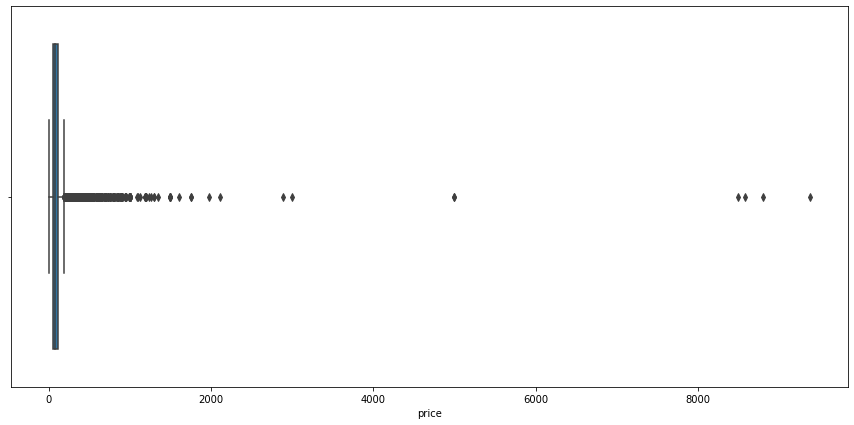

In [17]:
# Visualize Price Distribution
plt.figure(figsize=(15, 7))
sns.boxplot(df_global['price'])
plt.show()

##### Many outliers! We can't even see the moustache plot. Let's only keep listings whose price is below 1000  per night

In [18]:
# remove outliers
df_global = df_global[df_global['price'] <= 800]

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


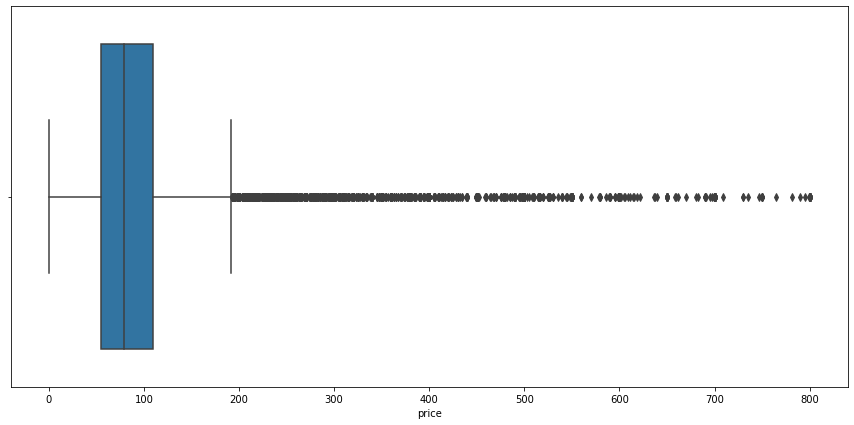

In [19]:
plt.figure(figsize=(15, 7))
sns.boxplot(df_global['price'])
plt.show()

/Users/ferialyahiaoui/.pyenv/versions/3.7.6/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Comments:
- Almost all listings (99%) have a price contained within 0 and 200$ daily.
- 50% of listings have a price that vary between 55$ and 119$ (IQR). 50% outside this range.
- Overall, the mean price is around 100$ daily.
- We observe some spikes at 'round' values such 200, 300, 400, ..., 1000, etc.


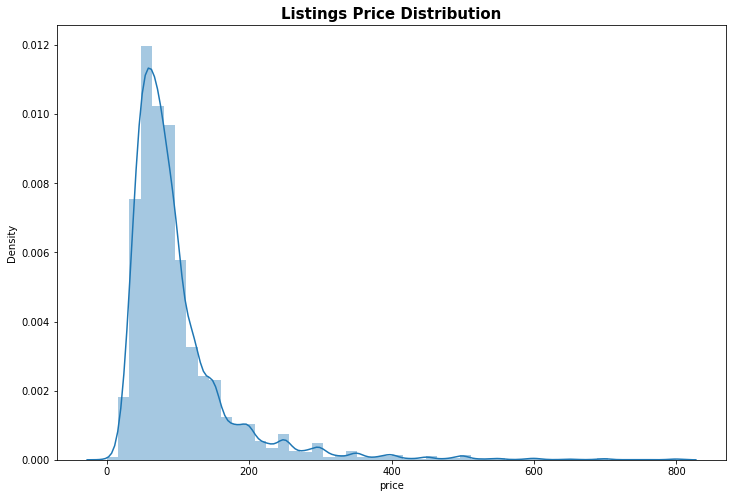

In [21]:
plt.figure(figsize=(12, 8))
plt.title("Listings Price Distribution", fontsize=15, fontweight='bold')
sns.distplot(df_global["price"])

print("Comments:\n\
- Almost all listings (99%) have a price contained within 0 and 200$ daily.\n\
- 50% of listings have a price that vary between 55$ and 119$ (IQR). 50% outside this range.\n\
- Overall, the mean price is around 100$ daily.\n\
- We observe some spikes at 'round' values such 200, 300, 400, ..., 1000, etc.")

Let's try to get a better understanding of price variation by visualizing geographically our data:
- We visualize the listings categorized as "Entire Home/apt" on a map.

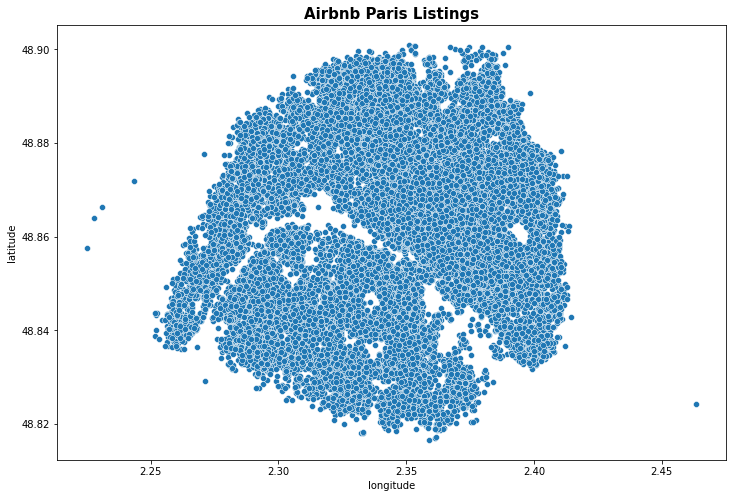

In [22]:
plt.figure(figsize=(12, 8))
plt.title("Airbnb Paris Listings", fontsize=15, fontweight='bold')
sns.scatterplot(x="longitude", y="latitude", data=df_global)
plt.show()

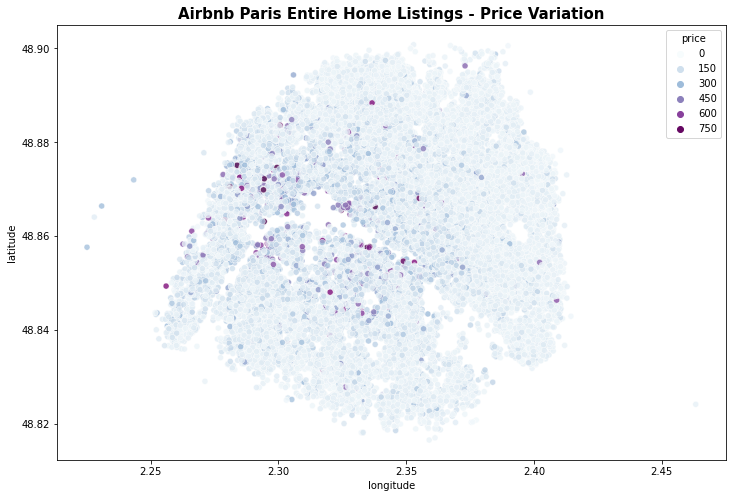

As we could expect, higher prices listings are in the heart of Paris and close to touristic places


In [23]:
plt.figure(figsize=(12, 8))

plt.title("Airbnb Paris Entire Home Listings - Price Variation", fontsize=15, fontweight='bold')
data_entire_home = df_global[df_global["room_type"] == "Entire home/apt"]
sns.scatterplot(x="longitude",
                y="latitude",
                hue="price",
                alpha=0.8,
                palette="BuPu",
                data=data_entire_home)

plt.show()

print("As we could expect, higher prices listings are in the heart of Paris and close to \
touristic places")

- To make sure the column `neighbourhood_cleansed` is cleaned by observing the data points with varying color depending on the neighbourhood.

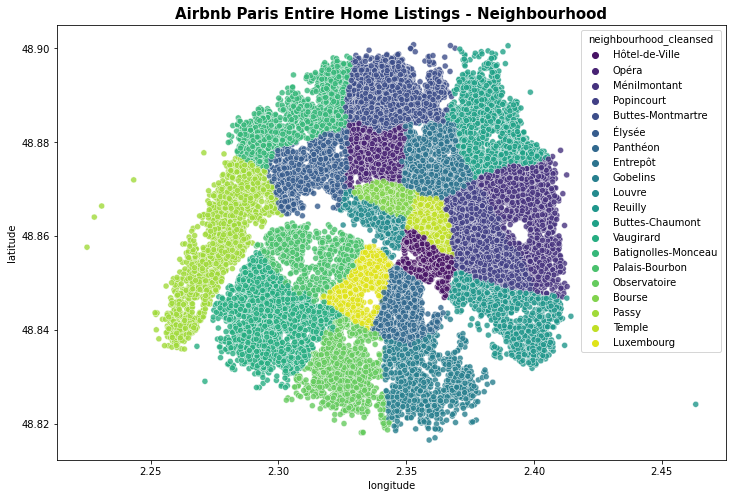

Variable `neighbourhood_cleansed` seems to be clean


In [24]:
plt.figure(figsize=(12, 8))

plt.title("Airbnb Paris Entire Home Listings - Neighbourhood", fontsize=15, fontweight='bold')
data_entire_home = df_global[df_global["room_type"] == "Entire home/apt"]
sns.scatterplot(x="longitude",
                y="latitude",
                hue="neighbourhood_cleansed",
                alpha=0.8,
                palette="viridis",
                data=data_entire_home)

plt.show()

print("Variable `neighbourhood_cleansed` seems to be clean")

- We're going to compute **median price depending on the neighbourhood**. Which districts appear the most and the less expensive?
Then
- We will draw a nice visualization of these prices discrepancies (differences).

In [25]:
median_price_per_district = df_global.groupby("neighbourhood_cleansed")["price"].median().sort_values()
print(median_price_per_district, '\n')


print("\
- Ménilmontant appears as the cheapest district\n\
- Élysée appears as the most expensive")

neighbourhood_cleansed
Ménilmontant            60.0
Buttes-Chaumont         60.0
Gobelins                65.0
Buttes-Montmartre       66.0
Reuilly                 69.0
Popincourt              70.0
Observatoire            70.0
Batignolles-Monceau     70.0
Entrepôt                75.0
Vaugirard               80.0
Opéra                   87.5
Panthéon                90.0
Passy                   98.0
Bourse                  99.0
Palais-Bourbon         105.0
Temple                 105.0
Luxembourg             110.0
Hôtel-de-Ville         110.0
Louvre                 116.0
Élysée                 119.0
Name: price, dtype: float64 

- Ménilmontant appears as the cheapest district
- Élysée appears as the most expensive


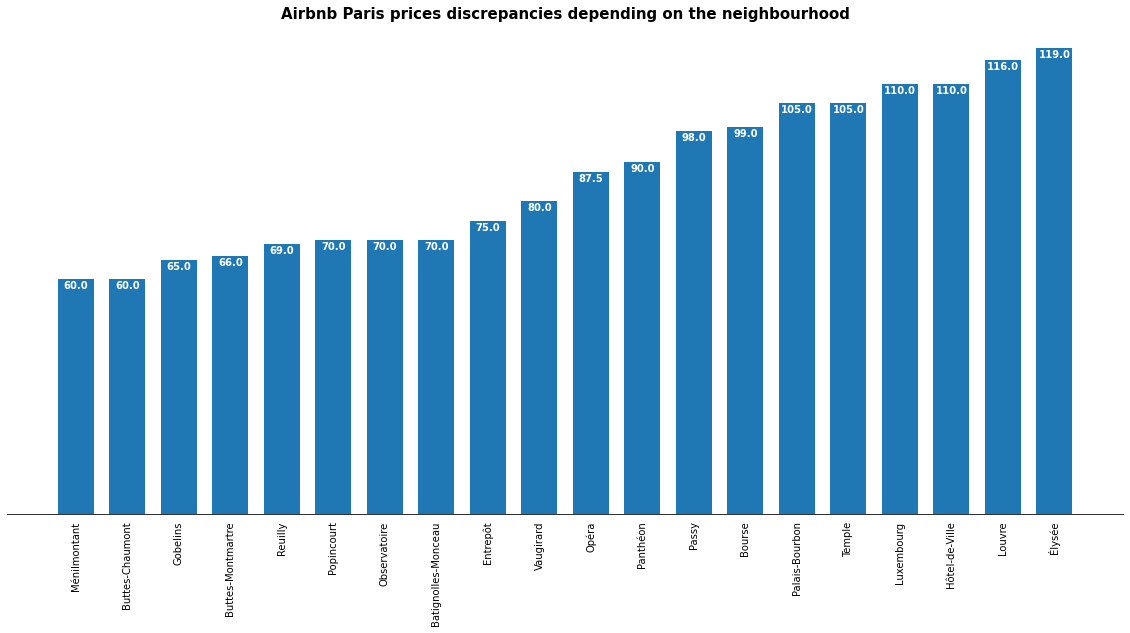

In [26]:
# We can visualize median_price_per_district with an histogram
# METHOD1

plt.figure(figsize=(20, 9))

# make plot
plt.bar(x=median_price_per_district.index, height=median_price_per_district, width=.7)

# style plot
sns.despine(left=True)
plt.xticks(rotation=90)
plt.yticks([])

for idx, value in enumerate(median_price_per_district):
    plt.text(x=idx, y=median_price_per_district[idx] - .5, s=round(median_price_per_district[idx], 1),
    ha='center', va='top', color='white', fontweight='bold')
    
plt.tick_params(bottom=False)
    
plt.title('Airbnb Paris prices discrepancies depending on the neighbourhood', fontsize=15, fontweight='bold')

plt.show()

- Or we can even display data points with mean price per district.
- To do that, we first need to add a column to our DataFrame

- To create new column `median_price_per_district`, we apply the function lambda that maps the key district to its mean price. Ex: median_price_per_district["Louvre"] = 115

In [27]:
data_entire_home["median_price_per_district"] = data_entire_home["neighbourhood_cleansed"].apply(
    lambda x: median_price_per_district[x])

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


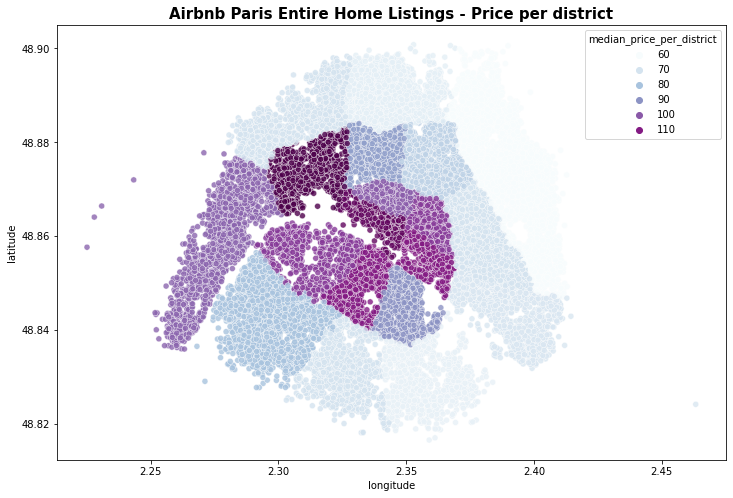

Central neighbourhoods appear more expensive as expected!


In [28]:
# METHOD 2

plt.figure(figsize=(12, 8))
plt.title("Airbnb Paris Entire Home Listings - Price per district", fontsize=15, fontweight='bold')
sns.scatterplot(x="longitude",
                y="latitude",
                hue="median_price_per_district",
                alpha=0.8,
                palette="BuPu",
                data=data_entire_home)
plt.show()
print("Central neighbourhoods appear more expensive as expected!")

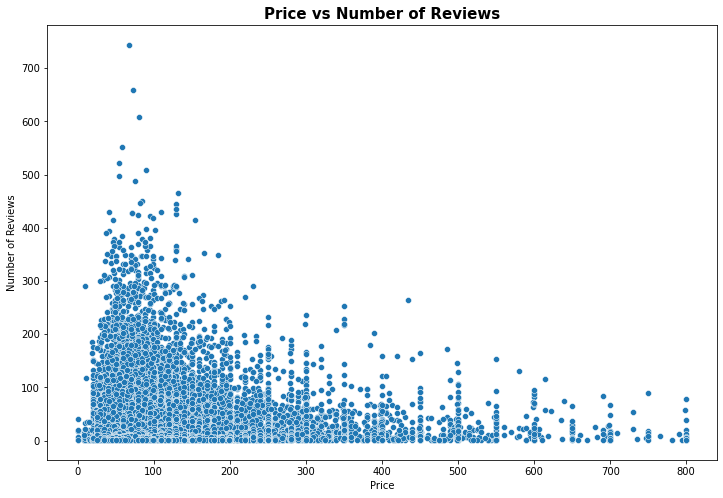

In [70]:
plt.figure(figsize=(12, 8))
plt.title('Price vs Number of Reviews', fontsize=15, fontweight='bold')
sns.scatterplot(x=df_global['price'], y=df_global['number_of_reviews'])
plt.xlabel('Price')
plt.ylabel('Number of Reviews')
plt.show()


From this plot, we see that most listings that cost around \\$100 - \\$200 get the most ratings. This is most likely due to the fact that people book Airbnb's for short stays so they are relatively cheaper. Also because of this plot, we notice that the cheaper the price the more reviews it gets.

# Feature engineering

In [21]:
df_global.isna().sum()

id                                     0
last_scraped                           0
host_name                              0
host_since                             0
host_location                         92
host_about                             0
host_is_superhost                      0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             47
bedrooms                              40
beds                                  15
bed_type                               0
amenities                              0
price                                  0
security_deposit                       0
cleaning_fee                           0
guests_included                        0
extra_people    

#### And we can add following calculated fields:

  -  `listing_duration` = (`last_review` - `first_review`) - value to be evaluated in days we have to convert the column to datetime object
  - `hosting_duration` = (`last_review`  - `host_since`) - value to be evaluated in days
  - `host_local` = if(‘Paris’ in host_location, 1, 0) - we will treat hosts from Paris as local
  - `host_about` = isna --> (host_about) - in this case nan will be counted as 0
  - `amenities` = count of listed amenities - since is comma delimited we will split and count number of list items
  - `price_per_person` - (`price`/`accommodates`)

#### convert categorical values into dummy variables:

- we will replace non-alphanumeric characters with underscores to prevent code errors

    `neighbourhood_cleansed`, 
    `property_type`, 
    `room_type`,
    `bed_type`,
    `cancellation_policy`


In [30]:
df_global['bed_type'].unique()

array(['Pull-out Sofa', 'Real Bed', 'Futon', 'Couch', 'Airbed'],
      dtype=object)

In [31]:
df_global['listing_duration'] = pd.to_datetime(df_global['last_review']) - pd.to_datetime(df_global['first_review'])

In [32]:
df_global['hosting_duration'] = pd.to_datetime(df_global['last_review']) - pd.to_datetime(df_global['host_since'])

## Variables Classification per type

### Numerical

#### Continuous
`bathrooms`, `bedrooms`, `beds`, `price_per_person`, `security_deposit`, `cleaning_fee`, `guests_included`, `extra_people`, `minimum_nights`, `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, `review_scores_value`, `calculated_host_listings_count`, `listing_duration`, `hosting_duration`, `host_about_len`, `total_amenities`.
#### Discrete
`host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`, `instant_bookable`, `require_guest_profile_picture`, `require_guest_phone_verification`, `host_local`.


### Categorical
`neighbourhood_cleansed` , `property_type`, `room_type`, `bed_type`, `cancellation_policy`.

In [33]:
df_global['require_guest_phone_verification'].unique()

array([0, 1])

In [34]:
#pd.options.display.max_columns = None
df_global['host_location'].str.contains('Paris|PARIS', regex=True)

2        False
3         True
4         True
5         True
7         True
         ...  
59639     True
59700     True
59706    False
59815     True
59875    False
Name: host_location, Length: 40316, dtype: object

In [35]:
# we treat hosts whose location is Paris as locals = 1. Else = 0
df_global['host_location'][df_global['host_location'].str.contains('Paris|PARIS', regex=True, na=False)==False]=0
df_global['host_location'][df_global['host_location'].str.contains('Paris|PARIS', regex=True, na=False)==True]=1

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# replace strings by their length
df_global['host_about'] = df_global['host_about'].str.len()

In [37]:
# replace list strings by their length

def replace_str_by_len(x):
    return len(x.split(','))

df_global['amenities'] = df_global['amenities'].apply(lambda x: replace_str_by_len(x))

#len(df_global['amenities'].iloc[50, ].split(','))

In [38]:
#create new column: 'price_per_person' = price/accommodates
df_global['price_per_person'] = df_global['price']/df_global['accommodates']

In [85]:
top_100 = df_global['number_of_reviews'].sort_values(ascending=False).iloc[0:100].to_list()

In [28]:
df_global.isna().sum()

id                                     0
last_scraped                           0
host_name                              0
host_since                             0
host_location                          0
host_about                             0
host_is_superhost                      0
host_has_profile_pic                   0
host_identity_verified                 0
neighbourhood_cleansed                 0
latitude                               0
longitude                              0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                             47
bedrooms                              40
beds                                  15
bed_type                               0
amenities                              0
price                                  0
security_deposit                       0
cleaning_fee                           0
guests_included                        0
extra_people    

In [39]:
df_global 

,id,last_scraped,host_name,host_since,host_location,host_about,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,...,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,listing_duration,hosting_duration,price_per_person
2,5396,2018-12-08,Borzou,2009-02-14,0,305,0,1,1,Hôtel-de-Ville,...,10.0,1,strict_14_with_grace_period,0,0,1,1.29,3431 days,3567 days,57.500000
3,7397,2018-12-08,Franck,2008-08-30,1,59,1,1,1,Hôtel-de-Ville,...,9.0,0,moderate,0,0,1,2.47,2782 days,3733 days,28.750000
4,7964,2018-12-08,Anaïs,2009-06-18,1,159,0,1,1,Opéra,...,10.0,0,strict_14_with_grace_period,0,0,1,0.06,1953 days,2279 days,49.500000
5,8522,2018-12-08,Adrien,2009-07-13,1,29,0,1,0,Ménilmontant,...,NaN,0,moderate,0,0,1,0.01,0 days,338 days,30.000000
7,9952,2018-12-08,Elisabeth,2009-08-24,1,636,1,1,0,Popincourt,...,10.0,0,strict_14_with_grace_period,0,0,1,0.24,2083 days,3386 days,35.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59639,30527590,2018-12-08,Arnaud,2014-06-04,1,136,0,1,0,Temple,...,NaN,0,strict_14_with_grace_period,0,0,1,1.00,0 days,1645 days,17.250000
59700,30550148,2018-12-08,Meggie,2010-08-14,1,560,0,1,1,Entrepôt,...,NaN,0,flexible,0,0,1,1.00,0 days,3037 days,29.750000
59706,30551052,2018-12-08,Edward,2012-07-31,0,344,0,1,0,Buttes-Chaumont,...,NaN,0,flexible,0,0,2,NaN,NaT,NaT,23.333333
59815,30578544,2018-12-08,Thibaut,2014-09-07,1,90,0,1,0,Buttes-Montmartre,...,NaN,0,flexible,0,0,1,1.00,0 days,1551 days,33.500000


In [40]:
df_global = df_global.dropna()

In [41]:
def clean_time_col(x):
    return int(str(x).replace(' days 00:00:00', ''))
               
df_global['listing_duration'] = df_global['listing_duration'].apply(lambda x: clean_time_col(x))

#int(str(df_global['listing_duration'].iloc[20, ]).replace(' days 00:00:00', ''))

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [42]:
df_global['listing_duration'][df_global['listing_duration'].isnull()]

Series([], Name: listing_duration, dtype: int64)

In [44]:
def clean_time_cln(x):
    x = str(x).replace('-', '')
    x = x.replace('+', '') 
    return int(x.replace(' days 00:00:00', ''))

df_global['hosting_duration'] = df_global['hosting_duration'].apply(lambda x: clean_time_cln(x))

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
df_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39112 entries, 2 to 59427
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39112 non-null  int64  
 1   last_scraped                      39112 non-null  object 
 2   host_name                         39112 non-null  object 
 3   host_since                        39112 non-null  object 
 4   host_location                     39112 non-null  object 
 5   host_about                        39112 non-null  int64  
 6   host_is_superhost                 39112 non-null  int64  
 7   host_has_profile_pic              39112 non-null  int64  
 8   host_identity_verified            39112 non-null  int64  
 9   neighbourhood_cleansed            39112 non-null  object 
 10  latitude                          39112 non-null  float64
 11  longitude                         39112 non-null  float64
 12  prop

In [50]:
def clean_column(x):
    return x.replace(' ', '_')

In [51]:
df_global['property_type'] = df_global['property_type'].apply(lambda x: clean_column(x))
df_global['room_type'] = df_global['room_type'].apply(lambda x: clean_column(x))
df_global['bed_type'] = df_global['bed_type'].apply(lambda x: clean_column(x))

/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ferialyahiaoui/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [49]:
df_global['cancellation_policy'].unique()

array(['strict_14_with_grace_period', 'moderate', 'flexible',
       'super_strict_30', 'super_strict_60'], dtype=object)

In [52]:
to_dummify = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']

to_scale = ['host_about', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 
            'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 
            'number_of_reviews', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value',
            'calculated_host_listings_count', 'reviews_per_month', 'listing_duration', 'hosting_duration', 
            'price_per_person']

binary = ['host_location', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 
          'require_guest_profile_picture', 'require_guest_phone_verification']

target = ['price']

In [53]:
dummies = pd.get_dummies(df_global,
               columns=to_dummify,
               drop_first=True)

In [54]:
dummies = dummies.drop(['id', 'last_scraped', 'host_name', 'host_since', 'first_review', 'last_review'] + to_scale + binary + target, axis=1)

In [55]:
scaled = df_global[to_scale]

In [56]:
X = pd.concat([scaled, dummies, df_global[binary]], axis=1)
y = df_global[target]

In [57]:
print(X.shape, y.shape)

(39112, 86) (39112, 1)


In [58]:
#In order to avoid data leaking whilst scaling, we have to split data into train and test, 
##before fitting with the scaling process.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [59]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Basic Modeling
### Simple LightGBM Regressor

In [60]:
gbm = LGBMRegressor()
gbm.fit(X_train_scaled, y_train.values.ravel())

##### Define a function to print all the results for train and test for a given model

In [75]:
def print_metrics(model, X_train, y_train, X_test, y_test):
    print('Train dataset')
    print('-------------')
    print('MAE is: ', mean_absolute_error(y_train, model.predict(X_train)))
    print('MSE is: ', mean_squared_error(y_train, model.predict(X_train)))
    print('RMSE is: ', sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print('R2 score is: ', r2_score(y_train, model.predict(X_train)))
                          

    print('-------------')
    print('-------------')

    print('Test dataset')
    print('-------------')
    print('MAE is: ', mean_absolute_error(y_test, model.predict(X_test)))
    print('MSE is: ', mean_squared_error(y_test, model.predict(X_test)))
    print('RMSE is: ', sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print('R2 score is: ', r2_score(y_test, model.predict(X_test)))

### Explaining regression metrics

- Mean Absolut Error: is the mean of all absolute prediction errors obtained by computing the value of prediction errors **(TargetValue - PredictedValue)** for each row of data and get their absolute value. This metric cannot really tell if the model is overfitting or underfitting because individual differences are summed. Though MAE close to 0 implies that the model is generallizing well and quite accurate.



- Mean Squared Error: is the mean squared difference between the actual values and predicted values. Larger errors participates in getting a large mean error (squared). Thus this metric penalizes the heavy outliers.



- Root Mean Squared Error : as we compute the squares of the residuals, we can take the square root in order to have the same unit as the data points. In our case, the RMSE for our listing price regression model will be in \\$ and will correspond to the mean error of our regression model.



- The coefficient of determination (R^2 score): it gives an indication of how much are the true value and the predicted value correlated? Its value is between 0 and 1 and: so it is close to 0 when values are not correlated at all (random noise) and it is close to 1 when values are highly correlated (even negatively). This means that knowing one helps a lot knowing the other.

In [76]:
print_metrics(gbm, X_train_scaled, y_train, X_test_scaled, y_test)

Train dataset
-------------
MAE is:  1.0209632178454382
MSE is:  10.844918935789364
RMSE is:  3.2931624520799705
R2 score is:  0.9981270472997289
-------------
-------------
Test dataset
-------------
MAE is:  1.2268562600844881
MSE is:  17.933756192237492
RMSE is:  4.234826583490461
R2 score is:  0.9969979245863118


#### Interpreting results:

- The MAE result suggests that our model is not that accurate, but it can still make good predictions.
- The MSE resut indicates an overfitting case because test error is 7 times higher than training error.
- The RMSE result shows that the difference between the actual values and predicted values is about ~4 \\$.
- The R2 score shows that our model fits data very well maybe too well (overfitting).

**Let's now tune our hypermarametrs LGBMRegressor model**

# Tuning LGBMRegressor

In [71]:
estimator = LGBMRegressor()

folds = KFold(n_splits=5,
              shuffle=True,
              random_state=42)

hyper_params = {
    'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.5, 1],
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'sub_feature': [0.5, 0.7, 1.0], 
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 100, 200],
    'num_leaves': [4, 8, 16, 32, 64, 128],
    'colsample_bytree': [1, 0.8, 0.5, 0.4],
    'n_estimators': [20, 40, 50, 100, 200, 300, 600, 1000, 5000]
}


random_search = RandomizedSearchCV(estimator, hyper_params, cv=folds, n_iter=100, n_jobs=-1, verbose=2)
random_search.fit(X_train_scaled, y_train.values.ravel())

print(f'Best parameters found by random search are: {random_search.best_params_}\n best score found by it is: {random_search.best_score_*100} \n best estimator found is: {random_search.best_estimator_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set with sub_feature=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0
Best parameters found by random search are: {'sub_feature': 1.0, 'num_leaves': 4, 'n_estimators': 5000, 'max_depth': 30, 'learning_rate': 0.2, 'colsample_bytree': 1, 'boosting_type': 'dart'}
 best score found by it is: 99.62629818515119 
 best estimator found is: LGBMRegressor(boosting_type='dart', colsample_bytree=1, learning_rate=0.2,
              max_depth=30, n_estimators=5000, num_leaves=4, sub_feature=1.0)


In [77]:
tun_estimator = LGBMRegressor(**random_search.best_params_)
tun_estimator.fit(X_train_scaled, y_train.values.ravel())

[LightGBM] [Warning] feature_fraction is set with sub_feature=1.0, colsample_bytree=1 will be ignored. Current value: feature_fraction=1.0


LGBMRegressor(boosting_type='dart', colsample_bytree=1, learning_rate=0.2,
              max_depth=30, n_estimators=5000, num_leaves=4, sub_feature=1.0)

In [78]:
print_metrics(tun_estimator, X_train_scaled, y_train, X_test_scaled, y_test)

Train dataset
-------------
MAE is:  0.383262297637124
MSE is:  3.134968341632709
RMSE is:  1.7705841808941785
R2 score is:  0.999458580792029
-------------
-------------
Test dataset
-------------
MAE is:  0.4679034317038838
MSE is:  4.502877129416223
RMSE is:  2.1219983811059384
R2 score is:  0.9992462272500988


**Results are much better with tuning the model**!!

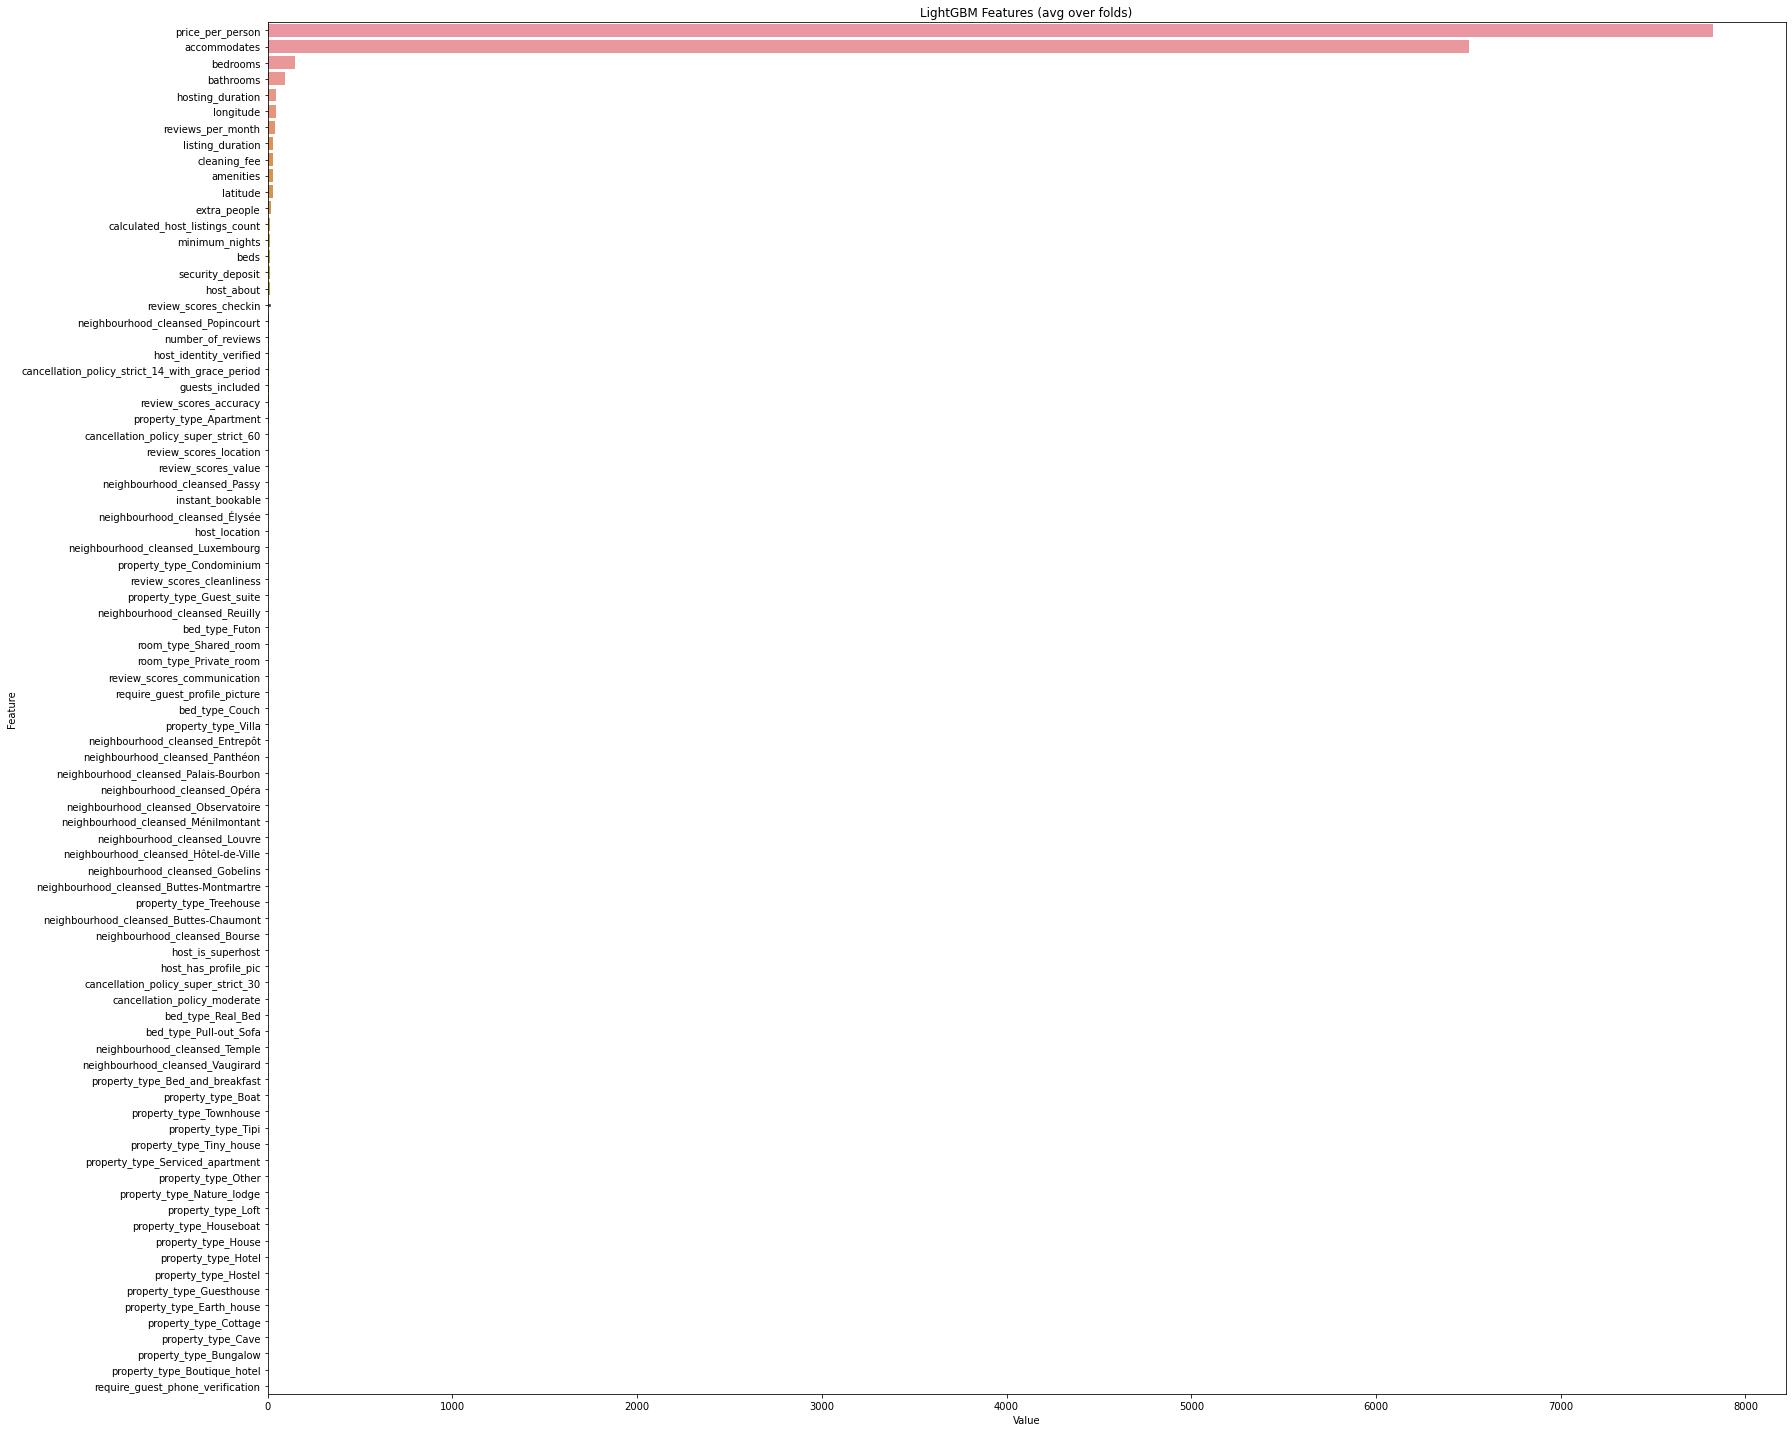

<Figure size 432x288 with 0 Axes>

In [84]:
feature_imp = pd.DataFrame(sorted(zip(tun_estimator.feature_importances_, X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(25, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances_model_tuned.png')

**`price_per_person` and `accomodates` seem to be the most important features used by our model**.